# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
mouseline = 'line3'  # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
rel_std_bounds = None  # critical relative variation factor determining valid range boundaries
ykeys_plt = [  # Plotting variables
    Label.DFF,
    Label.ZSCORE, 
    # Label.EVENT_RATE
]
plot_rasters = False
plot_traces = False

### Derived parameters

In [4]:
# Get batch-related settings
dataset_group_id, processed_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

# Set ON/OFF execution flags
skip_rasters = not plot_rasters
skip_traces = not plot_traces
 
# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 08/02/2023 20:54:45: assembling batch analysis settings...
 08/02/2023 20:54:45: line3 main analysis notebook started on 2023-02-08 at 20:54:45


### Input summary table figure

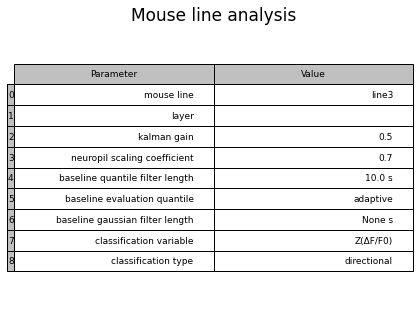

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional"
    }, title='Mouse line analysis', aspect=1.5)

### Load data

In [6]:
# Determine exclude patterns
exclude_patterns = {
    'line3': [
        # Yi
        '20191107_mouse1_region2',  # poor cell distribution & segmentation results
        '20191107_mouse1_region1',  # almost zero positive responder
        '20191113_mouse9_region1',  # presence of many dead cells?
        '20191113_mouse9_region2',  # presence of many dead cells?
        '20190829_mouse10_region1',  # almost zero positive responder
        # Celia
        '20191022_mouse1_region1',  # almost zero positive responder
        '20191023_mouse3_region1',  # only 3 conditions, suspicious cell distribution
    ],
    'sarah_line3': [
        
    ],
    'sst': [
        # '20190511_mouse7_region1',  # huge dFF values at .8MPa 50%DC
        # '20190513_mouse2_region1',  # huge dFF values across all DCs at .8MPa
        '20190516_mouse8_region1',  # almost zero positive responder
        '20190516_mouse8_region2',  # almost zero positive responder
        '20190706_mouse7_region1',  # huge peak at 0.1MPa
        '20190808_mouse6_region1',  # huge motion artefacts in initial run 
    ],
    'pv': [
        # '20190606_mouse2_region1',  # incomplete (no high DC data)
        # '20190606_mouse2_region2',  # incomplete (no high DC data), negative dips for positive responders
        # '20190821_mouse3_region1',  # noisy DC dependencies
        # # '20190702_mouse5_region1',  # super negative dip for P = 0.4 MPa
        # # '20190821_mouse6_region1',  # strong activations for low pressures, very noisy dFF profiles
        # # '20190630_mouse3_region1',  # super strong outlier at P = 0.4 MPa
        # # '20190821_mouse7_region1',  # super oscillatory profile
    ]
}[mouseline]

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {processed_dir}:')
data = load_processed_datasets(
    processed_dir, layer=layer,
    exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, map_ops = extract_from_batch_data(data)

# Define uniform palette
datasets = trialagg_stats.index.unique(Label.DATASET)
uniform_palette = dict(zip(datasets, ['silver'] * len(datasets)))

# Display ROI count per dataset & run, and highlight incomplete datasets
logger.info('detailed ROI count:')
get_detailed_ROI_count(trialagg_stats)

 08/02/2023 20:54:45: loading data from /Users/tlemaire/Documents/data/usnm/processed/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/line3:
 08/02/2023 20:54:45: excluding datasets with the following patterns:
 - 20191107_mouse1_region2
 - 20191107_mouse1_region1
 - 20191113_mouse9_region1
 - 20191113_mouse9_region2
 - 20190829_mouse10_region1
 - 20191022_mouse1_region1
 - 20191023_mouse3_region1
 08/02/2023 20:54:45: loading mouse-region data from 20190704_mouse2_region1.h5
 08/02/2023 20:54:46: loading mouse-region data from 20190704_mouse3_region1.h5
 08/02/2023 20:54:47: loading mouse-region data from 20190707_mouse1_region1.h5
 08/02/2023 20:54:47: loading mouse-region data from 20190807_mouse5_region1.h5
 08/02/2023 20:54:48: loading mouse-region data from 20190807_mouse6_region1.h5
 08/02/2023 20:54:48: loading mouse-region data from 20191023_mouse10_region1.h5
 08/02/2023 20:54:48

### Breakdown per mouse region & cell maps

 08/02/2023 20:56:14: identified 26.8% of responders with 0.33 as threshold proportion of responding conditions
 08/02/2023 20:56:14: plotting cell maps...


100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


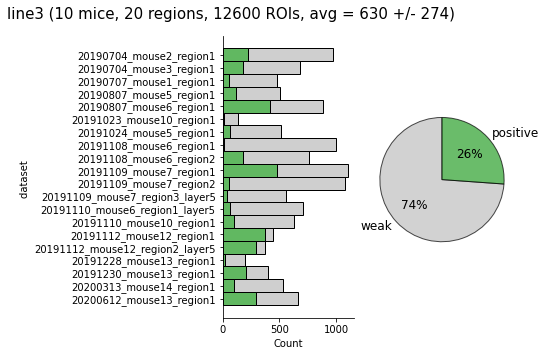

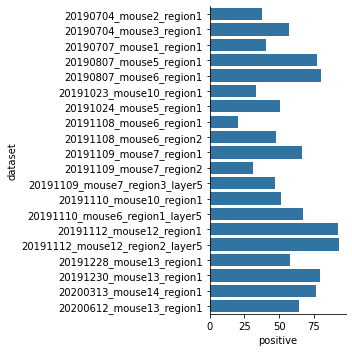

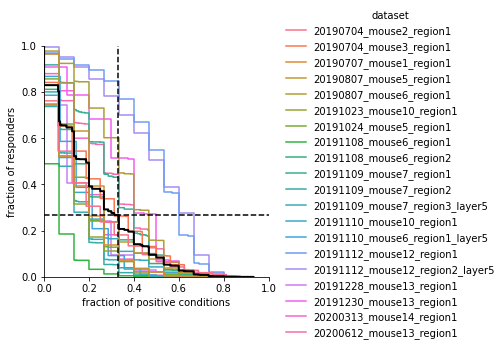

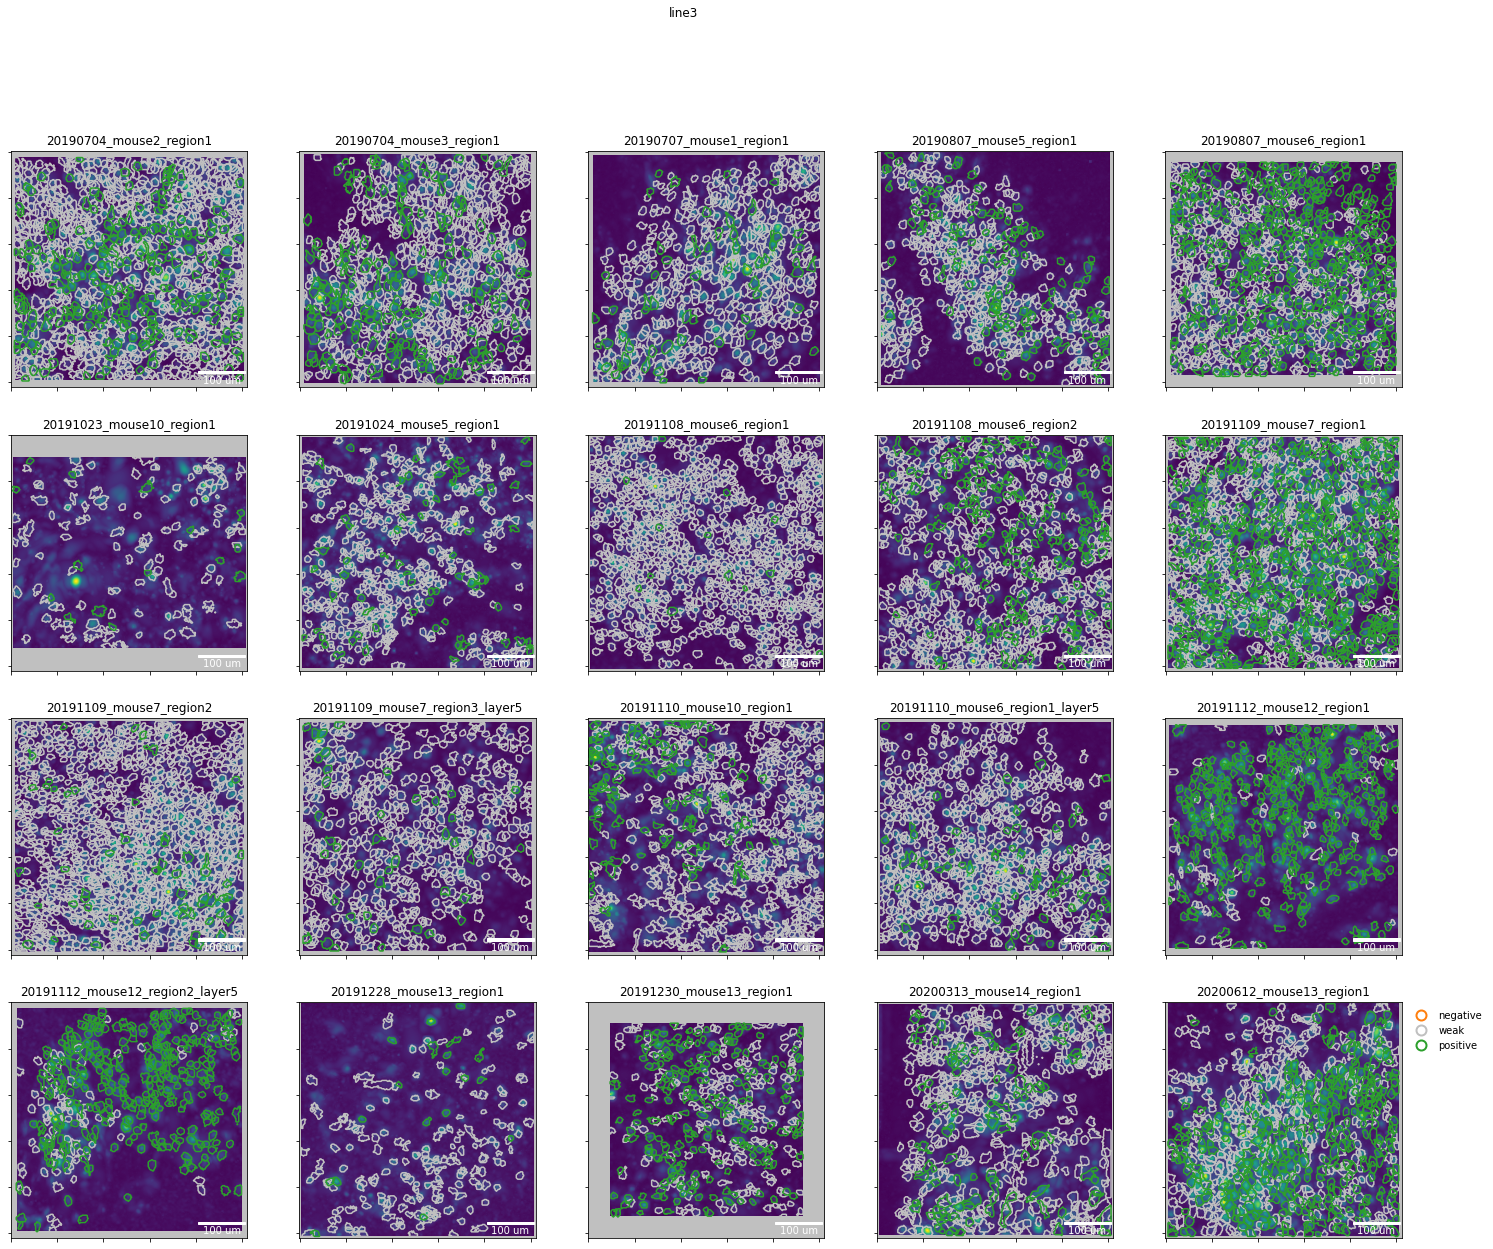

In [7]:
# Plot cell count breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(
    trialagg_stats, hue=Label.ROI_RESP_TYPE, title=mouseline)

# Plot distribution of max number of responders across conditions 
resp_counts = (
    trialagg_stats[Label.RESP_TYPE]
    .groupby([Label.DATASET, Label.RUN])
    .value_counts().unstack()
)
resp_counts['total'] = resp_counts.sum(axis=1)
resp_props = resp_counts.div(resp_counts['total'], axis=0) * 100
max_pos_props= resp_props['positive'].groupby(Label.DATASET).max()
max_pos_props = max_pos_props.to_frame().reset_index()
fg = sns.catplot(
    data=max_pos_props,
    kind='bar', 
    x='positive', 
    y=Label.DATASET,
    color='C0'
)
figs['max % resp'] = fg.figure

# Plot cell classification details 
figs['classification details'] = plot_classification_details(
    trialagg_stats, pthr=PROP_CONDS_THR, hue=Label.DATASET)

# Plot cell maps
figs['cellmaps'] = plot_cell_maps(
    ROI_masks, trialagg_stats, map_ops, title=mouseline, refkey='Vcorr', mode='contour')

### Visualize population average baseline evolution throughout experiments

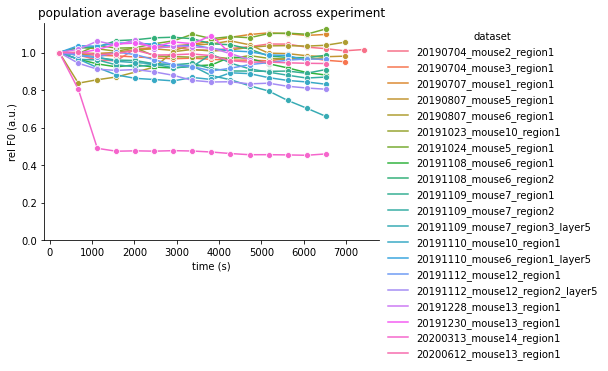

In [8]:
relF0_key = f'rel {Label.F0}'

def get_rel_F0(data, aggbyrun=True):
    ''' Extract temporal evolution of F0 '''
    # Figure out dataset ID and associated run order
    dataset_id = data.index.unique(Label.DATASET)[0]
    runid_map = trialagg_stats.loc[dataset_id, Label.RUNID].groupby(Label.RUN).first()
    # Extract frame rate from stats
    fps = get_singleton(trialagg_stats, Label.FPS)
    # Add time along entire experiment to population-average dataframe average
    data[Label.TIME] = get_index_along_experiment(data.index, runid_map=runid_map) / fps
    # If specified, aggregate by run
    data = data.groupby(Label.RUN).median()
    # Compute relative variation
    i0 = data[Label.TIME].idxmin()
    y0 = data.loc[i0, Label.F0]
    data[relF0_key] = data[Label.F0] / y0
    # Return data of interest
    return data[[Label.TIME, relF0_key]]

# Plot time evolution of average baseline along experiment, for each dataset
figs['popavg F0 across experiment'], ax = plt.subplots(figsize=(6, 4))
sns.despine(ax=ax)
ax.set_title(f'population average baseline evolution across experiment')
sns.lineplot(
    data=popagg_timeseries.groupby(Label.DATASET).apply(get_rel_F0),
    x=Label.TIME, 
    y=relF0_key, 
    ci=None, 
    ax=ax, 
    hue=Label.DATASET,
    marker='o'
)
ax.set_ylim(0, ax.get_ylim()[1])
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)

### Inspect run sequences per dataset and potential consequences on evoked activity

 08/02/2023 20:57:14: plotting I_SPTA (W/cm2) run sequence dependency across dataset...
 08/02/2023 20:57:14: run ID not part of (P (MPa), DC (%)) -> no filtering
 08/02/2023 20:57:14: sub-indexing data...
 08/02/2023 20:57:14: filtering data...
 08/02/2023 20:57:14: cross-checking filters...
 08/02/2023 20:57:14: grouping by dataset, averaging and plotting mean I_SPTA (W/cm2) vs. run ID ...
 08/02/2023 20:57:15: plotting evoked ΔF/F0 change run sequence dependency across dataset...
 08/02/2023 20:57:15: run ID not part of (P (MPa), DC (%)) -> no filtering
 08/02/2023 20:57:15: sub-indexing data...
 08/02/2023 20:57:15: filtering data...
 08/02/2023 20:57:15: cross-checking filters...
 08/02/2023 20:57:15: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. run ID ...
 08/02/2023 20:57:17: parameter sequences across datasets:


dataset 20190704_mouse2_region1 20190704_mouse3_region1  \
run ID                                                    
0                 0.80MPa_40%DC           0.80MPa_50%DC   
1                 0.80MPa_30%DC           0.80MPa_40%DC   
2                 0.80MPa_20%DC           0.80MPa_30%DC   
3                 0.80MPa_10%DC           0.80MPa_20%DC   
4                 0.80MPa_05%DC           0.80MPa_10%DC   
5                 0.80MPa_01%DC           0.80MPa_05%DC   
6                 0.00MPa_50%DC           0.80MPa_01%DC   
7                 0.60MPa_50%DC           0.00MPa_50%DC   
8                 0.40MPa_50%DC           0.60MPa_50%DC   
9                           NaN           0.40MPa_50%DC   
10                0.20MPa_50%DC           0.20MPa_50%DC   
11                0.10MPa_50%DC           0.10MPa_50%DC   
12                0.05MPa_50%DC           0.05MPa_50%DC   
13                0.80MPa_60%DC           0.80MPa_60%DC   
14                0.80MPa_70%DC           0.80MPa_70%DC   
15                0.80MPa_80%DC           0.80MPa_80%DC   
16                0.80MPa_50%DC                     NaN   

dataset 20190707_mouse1_region1 20190807_mouse5_region1  \
run ID                                                    
0                 0.80MPa_40%DC           0.80MPa_50%DC   
1                 0.80MPa_30%DC                     NaN   
2                 0.80MPa_20%DC           0.80MPa_40%DC   
3                 0.80MPa_10%DC           0.80MPa_30%DC   
4                 0.80MPa_05%DC           0.80MPa_20%DC   
5                 0.00MPa_50%DC           0.80MPa_10%DC   
6                 0.60MPa_50%DC           0.80MPa_05%DC   
7                 0.40MPa_50%DC           0.60MPa_50%DC   
8                 0.20MPa_50%DC           0.40MPa_50%DC   
9                 0.10MPa_50%DC           0.20MPa_50%DC   
10                0.05MPa_50%DC           0.10MPa_50%DC   
11                0.80MPa_60%DC           0.05MPa_50%DC   
12                0.80MPa_70%DC           0.00MPa_50%DC   
13                0.80MPa_80%DC           0.80MPa_60%DC   
14                0.80MPa_50%DC           0.80MPa_70%DC   
15                          NaN           0.80MPa_80%DC   
16                          NaN                     NaN   

dataset 20190807_mouse6_region1 20191023_mouse10_region1  \
run ID                                                     
0                 0.80MPa_50%DC            0.80MPa_80%DC   
1                 0.80MPa_40%DC            0.80MPa_70%DC   
2                 0.80MPa_30%DC            0.80MPa_60%DC   
3                 0.80MPa_20%DC            0.80MPa_50%DC   
4                           NaN            0.80MPa_40%DC   
5                 0.80MPa_05%DC            0.80MPa_30%DC   
6                 0.60MPa_50%DC            0.80MPa_20%DC   
7                 0.40MPa_50%DC            0.80MPa_10%DC   
8                 0.20MPa_50%DC            0.80MPa_05%DC   
9                 0.10MPa_50%DC            0.60MPa_50%DC   
10                0.05MPa_50%DC            0.40MPa_50%DC   
11                0.00MPa_50%DC            0.20MPa_50%DC   
12                0.80MPa_60%DC            0.10MPa_50%DC   
13                0.80MPa_70%DC            0.05MPa_50%DC   
14                0.80MPa_80%DC            0.00MPa_50%DC   
15                0.80MPa_10%DC                      NaN   
16                          NaN                      NaN   

dataset 20191024_mouse5_region1 20191108_mouse6_region1  \
run ID                                                    
0                 0.80MPa_80%DC           0.80MPa_50%DC   
1                 0.80MPa_70%DC           0.80MPa_40%DC   
2                 0.80MPa_60%DC           0.80MPa_30%DC   
3                 0.80MPa_50%DC           0.80MPa_20%DC   
4                 0.80MPa_40%DC           0.80MPa_10%DC   
5                 0.80MPa_30%DC           0.80MPa_05%DC   
6                 0.80MPa_20%DC           0.80MPa_60%DC   
7                 0.80MPa_10%DC           0.80MPa_70%DC   
8                 0.80MPa

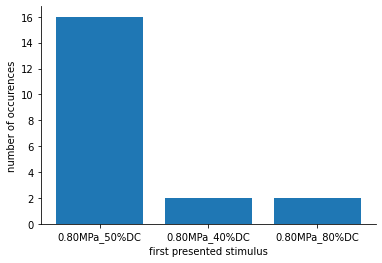

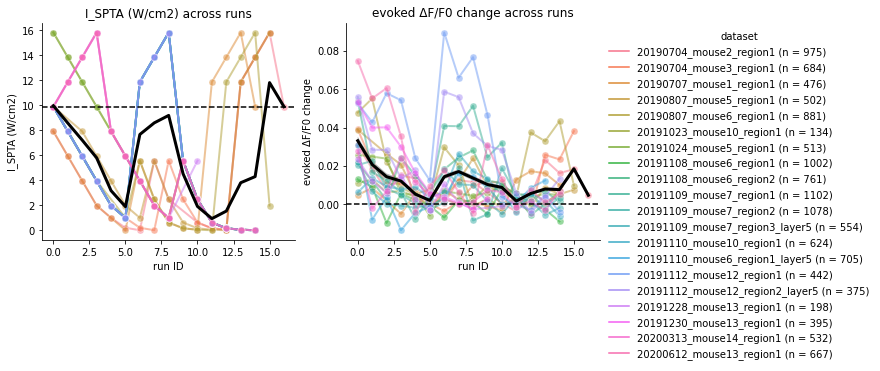

In [9]:
# Get parameter run sequence per dataset
param_seqs = trialagg_stats[[Label.RUNID, Label.P, Label.DC]].groupby([Label.DATASET, Label.RUNID]).first()
param_seqs = get_param_code(param_seqs).unstack().T

# Construct palette based on first presented parameters
first_params = param_seqs.loc[0, :]
first_params_mapper = dict(zip(
    first_params.unique(), 
    [f'C{i}' for i in range(first_params.nunique())]
))
first_param_palette = first_params.map(first_params_mapper).to_dict()

# Plot distribution of first persented stimulus
first_stims_dist = param_seqs.loc[0, :].value_counts()
figs['first stimulus distribution'], ax = plt.subplots(figsize=(2 * len(first_stims_dist), 4))
ax.set_xlabel('first presented stimulus')
ax.set_ylabel('number of occurences')
sns.despine(ax=ax)
ax.bar(first_stims_dist.index, first_stims_dist.values)

# Plot Ispta and evoked DFF across run sequences, per dataset
ykey_diff = get_change_key(Label.DFF)
ykeys_seq = [Label.ISPTA, ykey_diff]
Ispta_ref = pressure_to_intensity(P_REF / PA_TO_MPA) / M2_TO_CM2 * DC_REF / 1e2
figs['rundeps_global'], axes = plt.subplots(
    1, len(ykeys_seq), figsize=(5 * len(ykeys_seq), 4))
axes = np.atleast_1d(axes)
for i, (ykey, ax) in enumerate(zip(ykeys_seq, axes)):
    # Plot run sequence dependencies across datasets
    logger.info(f'plotting {ykey} run sequence dependency across dataset...')
    plot_parameter_dependency(
        trialagg_stats, xkey=Label.RUNID, ykey=ykey,
        yref=Ispta_ref if ykey == Label.ISPTA else 0., 
        hue=Label.DATASET, avgprop='whue', errprop='intra', ax=ax,
        legend=i == len(ykeys_seq) - 1, title=f'{ykey} across runs',
        ci=None, marker='o')

logger.info('parameter sequences across datasets:')
param_seqs

### Perform robust fit ISPTA <-> DFF^2

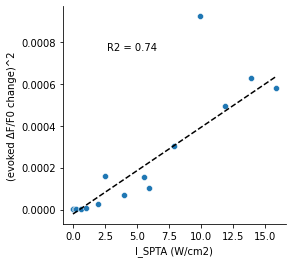

In [10]:
# Compute weighted average of output metrics across datasets
lineavg_stats = get_crossdataset_average(
    trialagg_stats, Label.RUN, ykey=ykey_diff).rename(columns={'mean': ykey_diff})
# Sort by increasing ISPTA
lineavg_stats = lineavg_stats.sort_values(Label.ISPTA)
# Perform linear fit between ISPTA and square of response stength
squared_ykey_diff = f'({ykey_diff})^2'
lineavg_stats[squared_ykey_diff] = lineavg_stats[ykey_diff]**2 * np.sign(lineavg_stats[ykey_diff])
b, m = robust_linreg(lineavg_stats[squared_ykey_diff], x=lineavg_stats[Label.ISPTA])
r2 = rsquared(lineavg_stats[squared_ykey_diff], m * lineavg_stats[Label.ISPTA] + b)
# Plot data and fitted profile
figs['isptafit'], ax = plt.subplots(figsize=(4, 4))
sns.despine(ax=ax)
sns.scatterplot(
    data=lineavg_stats, x=Label.ISPTA, y=squared_ykey_diff, ax=ax, ci=None, marker='o')
ax.plot(lineavg_stats[Label.ISPTA], m * lineavg_stats[Label.ISPTA] + b, '--k')
ax.text(0.2, 0.8, f'R2 = {r2:.2f}', transform=ax.transAxes);

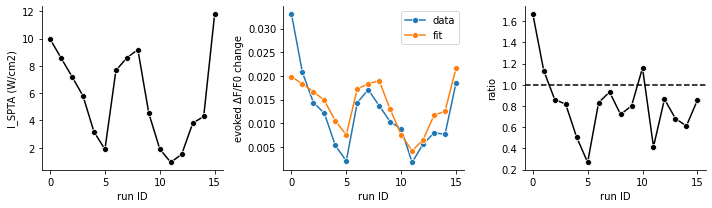

In [11]:
# Compute average ISPTA and response strength per run ID
runidavg_stats = get_crossdataset_average(
    trialagg_stats, Label.RUNID, ykey=ykey_diff).rename(columns={'mean': ykey_diff})
runidavg_stats[Label.ISPTA] = get_crossdataset_average(
    trialagg_stats, Label.RUNID, ykey=Label.ISPTA)['mean']

# Restrict to first 15 runs
runidavg_stats = runidavg_stats.iloc[:-1, :]

# Predict response strength over time bases on ISPTA fit
runidavg_stats['fit'] = np.sqrt(m * runidavg_stats[Label.ISPTA] + b).fillna(0.)

# Compute ratio of fit vs data to visualize potential drift ...
runidavg_stats['ratio'] = runidavg_stats[ykey_diff] / runidavg_stats['fit']

# Plot evolution of ISPTA and response strength (data & fit) over runs
figs['resp vs time - data vs. pred'], axes = plt.subplots(1, 3, figsize=(10, 3))
for ax in axes:
    sns.despine(ax=ax)
sns.lineplot(
    data=runidavg_stats, x=Label.RUNID, y=Label.ISPTA, ax=axes[0], marker='o', color='k')
sns.lineplot(data=runidavg_stats, x=Label.RUNID, y=ykey_diff, ax=axes[1], marker='o', label='data')
sns.lineplot(data=runidavg_stats, x=Label.RUNID, y='fit', ax=axes[1], marker='o', label='fit')
axes[1].legend()
sns.lineplot(
    data=runidavg_stats, x=Label.RUNID, y='ratio', ax=axes[2], marker='o', color='k')
axes[2].axhline(1., c='k', ls='--')
figs['resp vs time - data vs. pred'].tight_layout()

### Plot evoked change distribution for control condition (P = 0)

 08/02/2023 20:57:18: response type proportions at P = 0:
weak        93.953612
positive     6.046388
Name: response type, dtype: float64


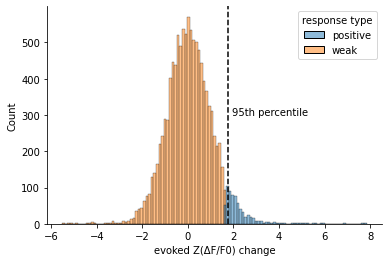

In [12]:
trialagg_stats0 = trialagg_stats[trialagg_stats[Label.P] == 0]
ykeydiff = get_change_key(Label.ZSCORE)

# Plot distribution of evoked response for baseline condition with response class color code
figs[f'{ykey_diff} dist baseline'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(
    ax=ax,
    data=trialagg_stats0,
    x=ykeydiff,
    hue=Label.RESP_TYPE,
)
# Add 95th percentile location
q95 = trialagg_stats0[ykeydiff].quantile(.95)
ax.axvline(q95, c='k', ls='--')
ax.text(1.1 * q95, 0.5 * ax.get_ylim()[1], '95th percentile')

# Log responder fraction information
props0 = trialagg_stats0[Label.RESP_TYPE].value_counts() / len(trialagg_stats0) * 100
logger.info(f'response type proportions at P = 0:\n{props0}')

### Plot parameter dependency curves

 08/02/2023 21:01:41: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 08/02/2023 21:01:41: plotting ΔF/F0 stimulation parameters dependencies across responders...
 08/02/2023 21:01:41: sub-indexing data...
 08/02/2023 21:01:41: filtering data...
 08/02/2023 21:01:41: cross-checking filters...
 08/02/2023 21:01:41: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 08/02/2023 21:01:43: sub-indexing data...
 08/02/2023 21:01:43: filtering data...
 08/02/2023 21:01:43: cross-checking filters...
 08/02/2023 21:01:43: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. DC (%) ...
 08/02/2023 21:01:43: plotting evoked ΔF/F0 change ISPTA dependency across responders...
 08/02/2023 21:01:43: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 08/02/2023 21:01:43: sub-indexing data...
 08/02/2023 21:01:43: filtering data...
 08/02/2023 21:01:43: cross-checking filters...
 08/02/2023 21:01:43: grouping by dataset, av

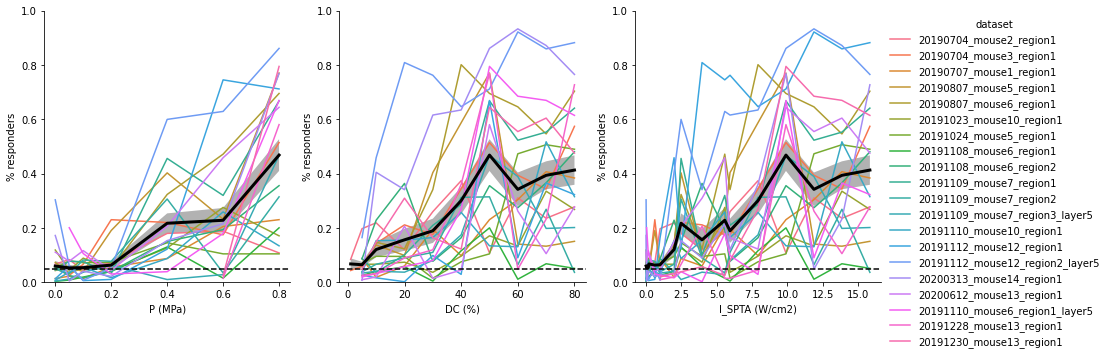

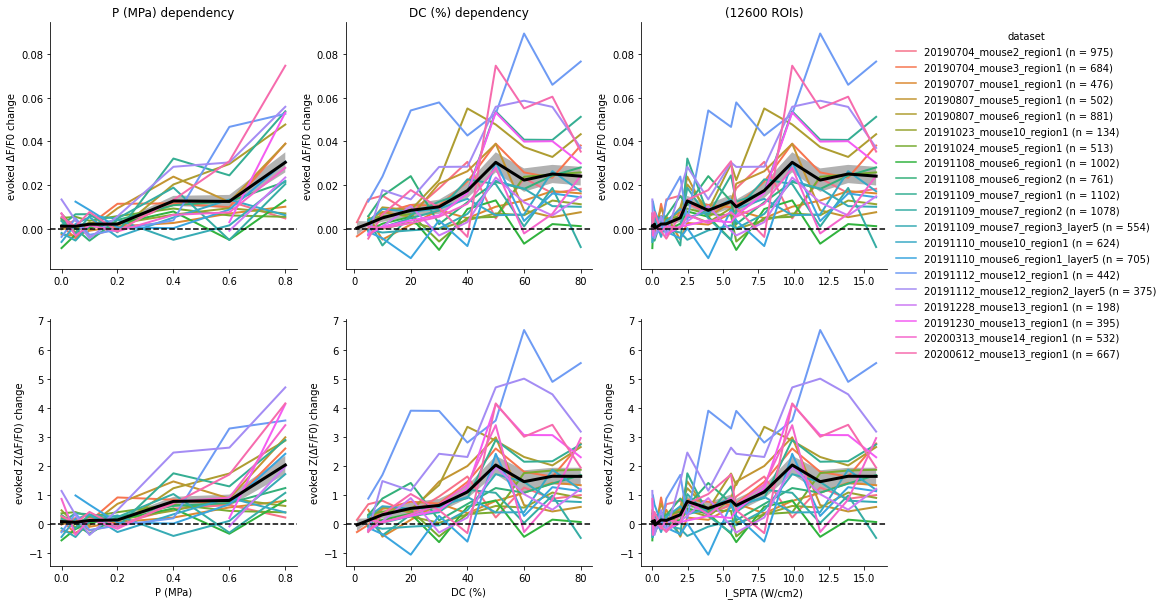

In [25]:
# Common plot parameters
fit = False
xkeys = [Label.P, Label.DC, Label.ISPTA]
palette = None
avg_color = 'k'
# palette = uniform_palette
# avg_color = {'line3': 'C0', 'pv': 'C1', 'sst': 'r'}[mouseline]
# palette = first_param_palette

# Proportion of responders
figs[f'respprop vs stimparams'], axes = plt.subplots(
    1, len(xkeys), figsize=(5 * len(xkeys), 5))
for i, (xkey, ax) in enumerate(zip(xkeys, axes)):
    legend = 'full' if i == len(xkeys) - 1 else False
    plot_responder_fraction(
        trialagg_stats, xkey,
        kind='line',
        hue=Label.DATASET,
        ax=ax,
        legend=legend,
        # hue_width=True
        palette=palette,
        avg_color=avg_color,
    )
if legend:
    sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)

# Response strength metrics
figs['stimparamdeps_global'], axes = plt.subplots(
    len(ykeys_plt), len(xkeys), figsize=(5 * len(xkeys), len(ykeys_plt) * 5))
axes = np.atleast_2d(axes)
for i, (ykey, axrow) in enumerate(zip(ykeys_plt, axes)):
    # Determine output metrics key
    ykey_diff = get_change_key(ykey)
    legend = i == 0

    # # Plot param dependencies across datasets for each responder type separately
    # tmpaxes = []
    # for rtype, substats in trialagg_stats.groupby(Label.ROI_RESP_TYPE):
    #     figkey = f'{ykey}_stimparamdeps_{rtype}'
    #     logger.info(f'plotting {ykey} stimulation parameters dependencies for {rtype} responders...')
    #     logger.setLevel(logging.WARNING)
    #     figs[figkey] = plot_stimparams_dependency(
    #         substats, ykey_diff, yref=0, hue=Label.DATASET, 
    #         avgprop='whue', errprop='inter',
    #         hue_alpha=1.,
    #         lw=0,
    #         ci=None,
    #         fit=fit, 
    #     )
    #     figs[figkey].suptitle(f'{mouseline} - {rtype} responders')
    #     tmpaxes = tmpaxes + figs[figkey].axes
    #     logger.setLevel(logging.INFO)
    # harmonize_axes_limits(np.asarray(tmpaxes))

    # Plot dependencies on each parameter on separate axes
    logger.info(f'plotting {ykey} stimulation parameters dependencies across responders...')
    # plot_stimparams_dependency(
    #     trialagg_stats[trialagg_stats[Label.ROI_RESP_TYPE] =='positive'], 
    #     ykey=ykey_diff, yref=0., 
    #     hue=Label.ROI_RESP_TYPE, 
    #     axes=axrow,
    #     weighted=True,
    #     fit=fit,
    # )
    plot_stimparams_dependency(
        trialagg_stats, 
        ykey=ykey_diff, yref=0., 
        hue=Label.DATASET, hue_alpha=1.,
        avgprop='whue', 
        errprop='inter',
        err_style='band',
        axes=axrow,
        fit=fit,
        ci=None,
        xkeys=xkeys,
        palette=palette,
        avg_color=avg_color,
        legend=legend,
    )
    if legend:
        sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)
for axrow in axes[1:]:
    for ax in axrow:
        ax.set_title(None)
for axrow in axes[:-1]:
    for ax in axrow:
        ax.set_xlabel(None)

### Examine variability of responses

 08/02/2023 20:57:25: run not part of (P (MPa), DC (%)) -> no filtering


<AxesSubplot:title={'center':'dip test (H0: unimodal)'}, xlabel='pval', ylabel='Density'>

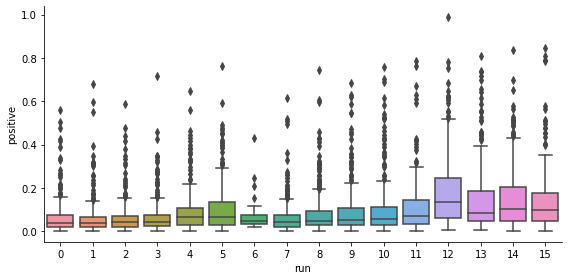

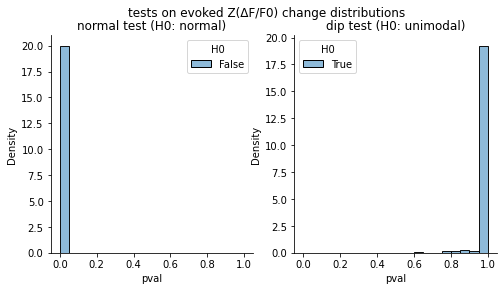

In [14]:
# Get fraction of responders for each dataset, run & trial
ext_resp_props = get_responders_counts(
    ext_stats, Label.RUN, units=[Label.DATASET, Label.TRIAL], normalize=True)

# Plot distirbution of responder fraction across datasets & trial, per condition
sns.catplot(
    data=ext_resp_props.reset_index(Label.RUN),
    kind='box',
    y='positive',
    x=Label.RUN,
    height=4,
    aspect=2
)

# Compute population-average stats for each trial 
popagg_stats = (
    ext_stats[[ykey_diff, Label.ISPTA, Label.RUNID]]
    .groupby([Label.DATASET, Label.RUN, Label.TRIAL])
    .mean()
)
popagg_stats[Label.RUNID] = popagg_stats[Label.RUNID].astype(int)

# testdata = ext_resp_props['positive']
testdata = ext_stats[ykey_diff]
testgroupby = [Label.RUN, Label.DATASET]
pthr = PTHR_DETECTION

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle(f'tests on {testdata.name} distributions')
sns.despine(fig=fig)
histkwargs = dict(
    x='pval',
    bins=np.linspace(0, 1, 21),
    stat='density',
    hue='H0'
)
# Test if distributions are normal
from scipy.stats import normaltest
isnormal = apply_test(
    testdata, testgroupby, normaltest, pthr=pthr)
axes[0].set_title('normal test (H0: normal)')
sns.histplot(
    ax=axes[0],
    data=isnormal,
    **histkwargs
)

# Test if distributions are multimodal
from diptest import diptest
ismultimodal = apply_test(
    testdata, testgroupby, diptest, pthr=pthr)
axes[1].set_title('dip test (H0: unimodal)')
sns.histplot(
    ax=axes[1],
    data=ismultimodal,
    **histkwargs
)

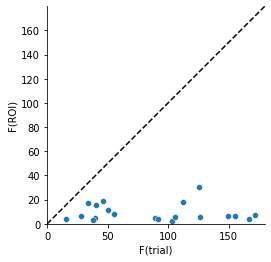

In [15]:
# For each dataset, compute 2-way ANOVA for trial vs. ROI
Ftable = ext_stats[ykey_diff].groupby(Label.DATASET).agg(compute_ROI_vs_trial_anova)
Ftable = pd.DataFrame(
    Ftable.tolist(),
    columns=[f'F({Label.TRIAL})', f'F({Label.ROI})'],
    index=Ftable.index
)
# Plot resulting F-scores on 2D scatter graph
fig, ax = plt.subplots()
sns.despine(ax=ax)
sns.scatterplot(
    data=Ftable,
    x=f'F({Label.TRIAL})',
    y=f'F({Label.ROI})',
    ax=ax
)
xymax = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(0, xymax)
ax.set_ylim(0, xymax)
ax.axline((0, 0), (1, 1), ls='--', color='k')
ax.set_aspect(1.)

### Plot dependency of response strength on stimulus presentation order

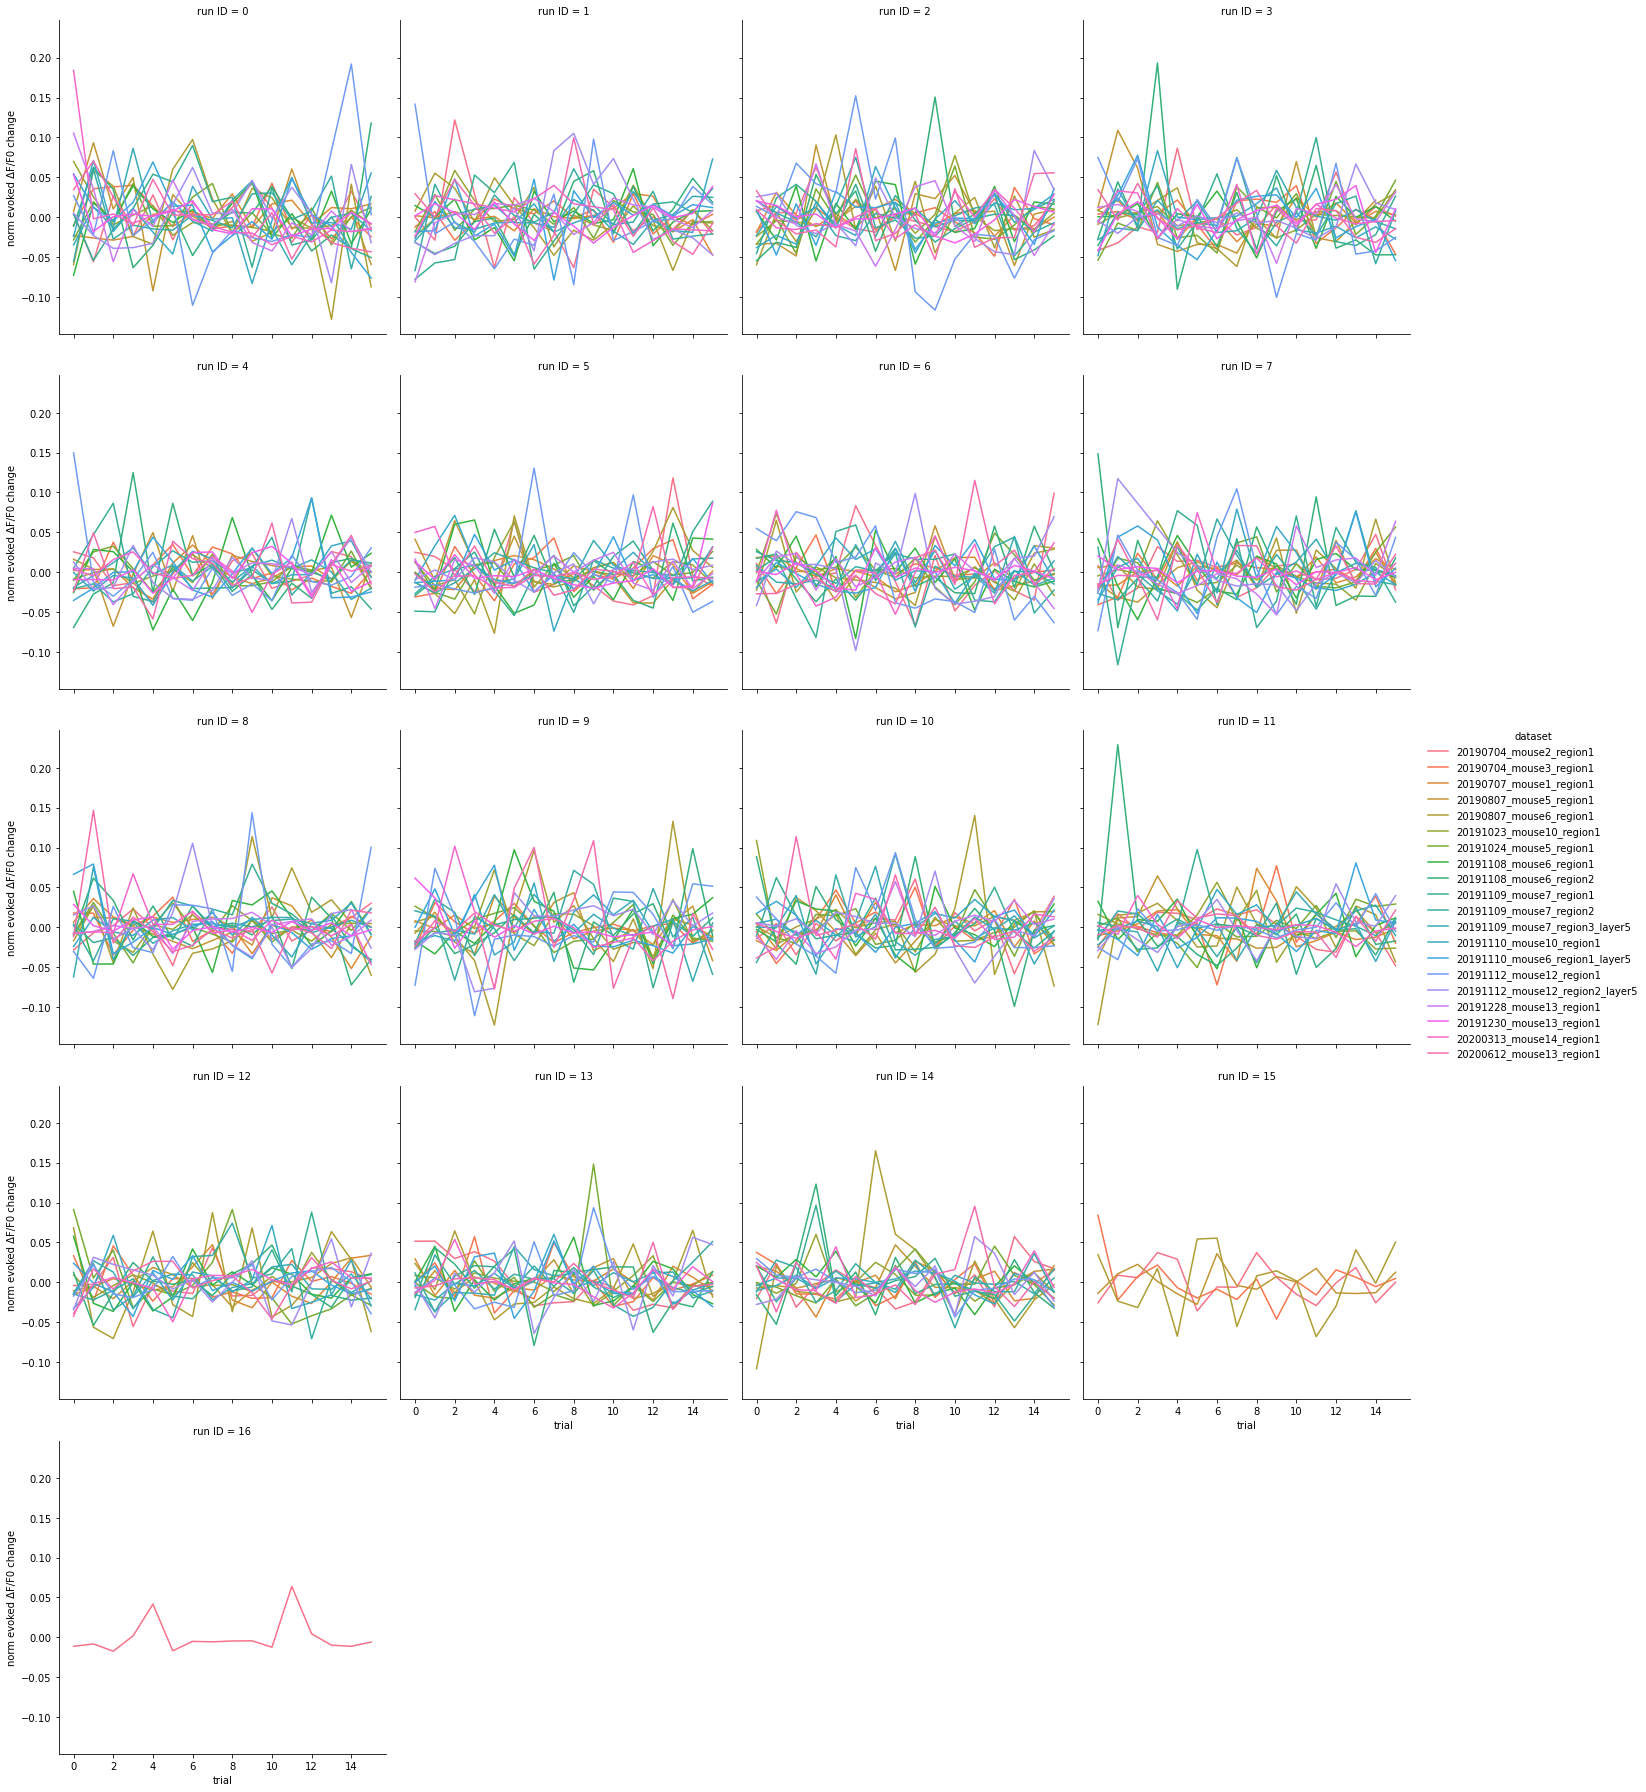

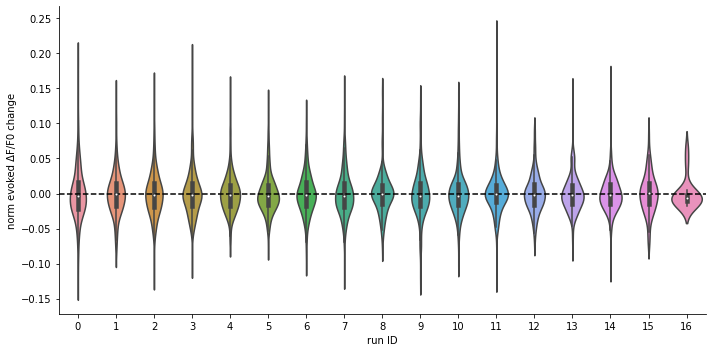

In [16]:
ykey_diff = get_change_key(Label.DFF)

# Compute population-average stats for each trial 
popagg_stats = (
    ext_stats[[ykey_diff, Label.ISPTA, Label.RUNID]]
    .groupby([Label.DATASET, Label.RUN, Label.TRIAL])
    .mean()
)
popagg_stats[Label.RUNID] = popagg_stats[Label.RUNID].astype(int)

# Haromnize response distributions for each run ID (these could be different
# conditions across datasets) by subtracting mean of response distribution for
# each dataset & run

# Normalize responses w.r.t to max value across run trials (per dataset & run)
normkey = f'norm {ykey_diff}'
popagg_stats[normkey] = (
    popagg_stats[ykey_diff]
    .groupby([Label.DATASET, Label.RUN])
    .apply(lambda s: s - s.mean())
)

# Plot
fg = sns.relplot(
    data=popagg_stats, 
    kind='line',
    y=normkey,
    x=Label.TRIAL,
    hue=Label.DATASET,
    col=Label.RUNID,
    # col=Label.RUN,
    col_wrap=4,
    ci=None, 
    # ci=68,
    legend='full',
)

# Plot distribution of 
fg = sns.catplot(
    data=popagg_stats, 
    kind='violin',
    y=normkey,
    x=Label.RUNID,
    aspect=2,
    # hue=Label.DATASET,
    # col=Label.RUNID,
    # palette='tab20'
)
fg.figure.axes[0].axhline(0, c='k', ls='--')
figs['popagg_variance_vs_runiD'] = fg.figure

### Plot trial heatmap per condition for entire mouse line

In [17]:
%%skip $skip_rasters

# # Get proportion of each response type per condition and dataset
# respcounts = trialagg_stats[Label.RESP_TYPE].groupby([Label.DATASET, Label.RUN]).value_counts()
# totcounts = respcounts.groupby([Label.DATASET, Label.RUN]).sum()
# respprops = respcounts / totcounts
# respprops = respprops.unstack().fillna(0)
# # Get datasets & conditions yelding high proportions of positive and negative responders
# negresps = respprops[respprops['negative'] >= 0.5]['negative'].sort_values(ascending=False).to_frame()
# negresps['color'] = Palette.RTYPE['negative']
# posresps = respprops[respprops['positive'] >=0.5]['positive'].sort_values(ascending=False).to_frame()
# posresps['color'] = Palette.RTYPE['positive']
# extreme_conds = pd.concat([negresps, posresps], axis=0)
# rect_markers = extreme_conds['color']
rect_markers = None

sorted_ISPTAs = stats[Label.ISPTA].groupby(Label.RUN).first().sort_values().apply(
    '{:.2f} W/cm2'.format)
fps = get_singleton(stats, Label.FPS)
for ykey in ykeys_plt:
    figs[f'{ykey} heatmap'] = plot_trial_heatmap(
        trialagg_timeseries, ykey, fps, col=Label.RUN,
        col_order=sorted_ISPTAs.index.values, 
        col_labels=sorted_ISPTAs.values,
        rasterized=True,
        colwrap=len(sorted_ISPTAs), 
        sort_ROIs=True,
        rect_markers=rect_markers
    )

### Plot response traces

In [18]:
%%skip $skip_traces

# Get plot-ready traces dataset
plt_data = get_plot_data(trialagg_timeseries, trialagg_stats)

# Align DFF and z-score traces w.r.t their pre-stimulus average
plt_data.loc[:, [Label.DFF, Label.ZSCORE]] = align_at(
    plt_data[[Label.DFF, Label.ZSCORE]], FrameIndex.PRESTIM)

# Get onset slice
mux_slice = slice_last_dim(plt_data.index, FrameIndex.STIM)

# Determine input parameters
pkeys = [Label.P, Label.DC]

# Determine whether to group by responder type or not
groupby = None # Label.ROI_RESP_TYPE

# For each output variable
for ykey in ykeys_plt:

    # Pressure-dependent and dutcy cycle dependent response traces, per dataset
    for pkey in pkeys:
        figs.update(
            plot_responses_across_datasets(
                plt_data, ykey=ykey, pkey=pkey, groupby=groupby))

    # Global (weighted) response curves for both input stimulation parameters
    avgaxes = []  
    for pkey in pkeys:
        figs[f'{ykey} vs. {pkey} by type'] = plot_responses_across_datasets(
            plt_data, ykey=ykey, pkey=pkey, avg=True, groupby=groupby)
        avgaxes = avgaxes + figs[f'{ykey} vs. {pkey} by type'].axes
    harmonize_axes_limits(avgaxes)

### Save responder-type-averaged stats to disk

In [19]:
rtypeavg_dir = get_output_equivalent(
    os.path.split(processed_dir)[0], DataRoot.PROCESSED, DataRoot.LINESTATS)
fpath = os.path.join(rtypeavg_dir, f'{mouseline}.csv')
stats_per_rtype = get_crossdataset_average(trialagg_stats, Label.RUN, hue=Label.ROI_RESP_TYPE)
logger.info(f'saving responder-type-averaged stats to {fpath}...')
stats_per_rtype.to_csv(fpath)

 08/02/2023 20:57:35: saving responder-type-averaged stats to /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/line3.csv...


### Save figures

In [20]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 08/02/2023 20:57:35: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2023.02.08/figs_main_line3_k0.5_alpha0.7_qadaptive_wq10.0s_aggmedian_classzscore_directional.pdf:


100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


### Notify upon completion

In [21]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 08/02/2023 20:57:46: line3 batch notebook completed in 0:03:00.895252 s
